In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import tiktoken
from datasets import load_dataset


from deeppy import Network, IngpData, LearnFrame, FromLoader
from deeppy.models.cv import Sane
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:


data_config = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

window_size = 4096
batch_size = 16

data = IngpData(data_path="../nerfs", config = data_config, window_size=window_size)
print(data.token_size)
print(data.max_positions)

dloader = DataLoader(data, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle = True)

ddata = FromLoader(train_loader=dloader)

IndexError: list index out of range

In [3]:
input_dim = 32
embed_dim = 256
latent_dim = 256
num_heads = 4
num_layers = 4
window_size = window_size
max_positions = [500000,600,600]
dropout = 0.1
bias = False
projection_dim = 10


one_epoch_length = 1000
epochs = 50 * one_epoch_length

In [4]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : False,
    "amp":False,

}

model = dp.cv.Sane(**Sane_params)

# Inputs

In [5]:
cout = window_size
cr = input_dim

tokenized_input = torch.rand(size = (batch_size, cout, cr)).to(device)
mask = torch.ones(size = tokenized_input.size()).to(device)
positions = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

tokenized_input2 = torch.rand(size = (batch_size, cout, cr)).to(device)
mask2 = torch.ones(size = tokenized_input.size()).to(device)
positions2 = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

rots = torch.rand(size = (batch_size,3)).to(device)
print(f"Inp shape : {tokenized_input.shape}")
print(f"mask shape : {mask.shape}")
print(f"positions shape : {positions.shape}")



Inp shape : torch.Size([16, 4096, 32])
mask shape : torch.Size([16, 4096, 32])
positions shape : torch.Size([16, 4096, 3])


In [7]:
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))

(1.4172096252441406, 1.2284690141677856, 5.726250171661377, 0.5055005550384521)

In [8]:


#tokenized_input,positions,mask, tokenized_input2,positions2,mask2 = ddata.train_data()
tokenized_input,positions,mask, tokenized_input2,positions2,mask2 = ddata.train_data()

print(f"Inp shape : {tokenized_input.shape}")
print(f"mask shape : {mask.shape}")
print(f"positions shape : {positions.shape}")

NameError: name 'ddata' is not defined

## Encode

In [8]:
latent = model.encode((tokenized_input,positions))
print(f"Latent space : {latent.shape}")

Latent space : torch.Size([64, 64, 256])


In [9]:
T,p = (tokenized_input.to(device),positions.to(device))


T = model.autoencoder.model[0]((T,p))
print(f"Tokenized input : {T[0].shape}")

T = model.autoencoder.model[1](T)
T = model.autoencoder.model[2](T)
print(f"Position encoding + dropout : {T.shape}")

T = model.autoencoder.model[3](T)
print(f"After transformer encoder : {T.shape}")

latent = model.autoencoder.model[4](T)
print(f"Latent space : {latent.shape}")

Tokenized input : torch.Size([64, 64, 256])
Position encoding + dropout : torch.Size([64, 64, 256])
After transformer encoder : torch.Size([64, 64, 256])
Latent space : torch.Size([64, 64, 256])


## Decode

In [10]:
z = model.decode((latent,positions))
print(f"Output : {z.shape}")

Output : torch.Size([64, 64, 32])


In [11]:
T,p = (latent.to(device),positions.to(device))


T = model.autoencoder.model[5]((T,p))
print(f"Decoder compression : {T[0].shape}")

T = model.autoencoder.model[6](T)
T = model.autoencoder.model[7](T)
print(f"Decoder position encoding + dropout : {T.shape}")

T = model.autoencoder.model[8](T)
print(f"Decoder transformer : {T.shape}")

z = model.autoencoder.model[9](T)
print(f"Output : {z.shape}")

Decoder compression : torch.Size([64, 64, 256])
Decoder position encoding + dropout : torch.Size([64, 64, 256])
Decoder transformer : torch.Size([64, 64, 256])
Output : torch.Size([64, 64, 32])


## Autoencoder Full Pass

In [12]:
z,y, zp = model((tokenized_input,positions))
print(f"Output : {y.shape}")

Output : torch.Size([64, 64, 32])


# Projection Head

In [13]:
model.project

Network(
  (model): Sequential(
    (0): SqueezeLastDimention()
    (1): Linear(in_features=16384, out_features=10, bias=False)
    (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=False)
    (5): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
  )
)

In [14]:
latent = model.encode((tokenized_input,positions))
p = model.project(latent)
print(f"Latent size : {latent.shape}")
print(f"Projection head output size : {p.shape}")

Latent size : torch.Size([64, 64, 256])
Projection head output size : torch.Size([64, 10])


# Create A LearnFrame

In [15]:
lf = LearnFrame(model,ddata)

NameError: name 'ddata' is not defined

In [6]:
lf.optimize()

(6.257178783416748, 1.00434148311615, 3.275937795639038, 4.117039203643799)

# Train a Batch

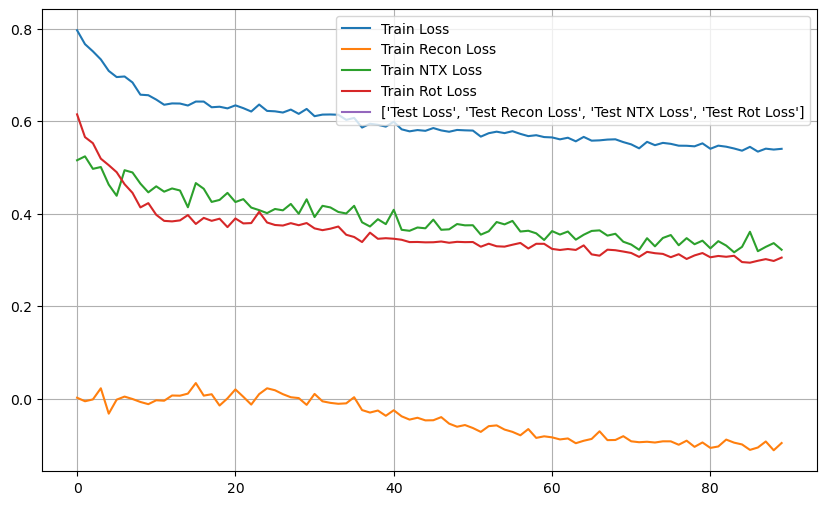

<Figure size 640x480 with 0 Axes>

In [ ]:
import time

st = time.time()
for i in range(300):
    lf.optimize()
    if i%100 == 0:
        lf.plot(show_result = False, log = True)
print(time.time()-st)
lf.plot(show_result = True, log = True)

In [14]:
#AMP Enabled  39.35s

# Test a Batch

In [15]:
lf.test()
print(f"Loss train : {lf.metric.test_data[-1]}")

Loss train : 2.5419931411743164


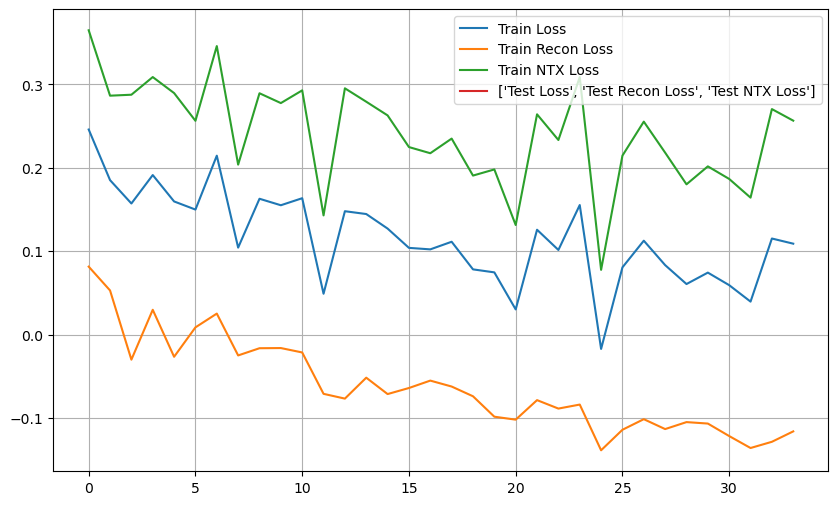

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
lf.plot(show_result = True, log = True)

In [7]:
import time

# Test

In [6]:
def optimize_test_time(model):
    cout = window_size
    cr = input_dim

    tokenized_input = torch.rand(size = (batch_size, cout, cr)).to(device)
    mask = torch.ones(size = tokenized_input.size()).to(device)
    positions = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

    tokenized_input2 = torch.rand(size = (batch_size, cout, cr)).to(device)
    mask2 = torch.ones(size = tokenized_input.size()).to(device)
    positions2 = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

    rots = torch.rand(size = (batch_size,3)).to(device)

    start_event = torch.cuda.Event(enable_timing=True)

    model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))



## Vanilla

In [10]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : False,
    "amp":False,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))



(1.5559914112091064, 1.3085711002349854, 7.043848514556885, 0.5217000842094421)

In [11]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

optimize_test_time(model)

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

Elapsed time: 0.094703 seconds


## Torch compile

In [7]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : True,
    "amp":False,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))


(1.3616125583648682, 1.1827006340026855, 5.274228096008301, 0.6694096326828003)

In [11]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

n_times = 100
for i in range(n_times):
    optimize_test_time(model)

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event) / n_times  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

Elapsed time: 1.152807 seconds


## AMP

In [6]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : False,
    "amp":True,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))


tensor(1.4955, device='cuda:0', grad_fn=<AddBackward0>)


AssertionError: No inf checks were recorded prior to update.

In [ ]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

for i in range(100):
    model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

In [15]:
model.optimizer.scaler.is_enabled()

True